## Graduation Research 

## Conduct PCA

In [ ]:
# 1次元に引き延ばす(PCAで使用)                                                                                              
def flatten_image(img):

    s = img.shape[0] * img.shape[1] #* img.shape[2]
    img_wide = img.reshape(1, s)
    return img_wide[0]


def handle_image_with_pca(activations, y_test, channel):
    """
    分類分布をPCAにて取得
    """
    for i in range(4):
        images = activations[i,:,:,:]
        if i == 0:
            labels = y_test[:channel]
        elif i == 1:
            labels = y_test[channel:channel*2]
        elif i == 2:
            labels = y_test[channel*2:channel*3]
        elif i == 3:
            labels = y_test[channel*3:]
        ls = []
        for label in labels:

            if list(label) == [1,0,0,0]:
                ls.append("class_A")
            elif list(label) == [0,1,0,0]:
                ls.append("class_B")
            elif list(label) == [0,0,1,0]:
                ls.append("class_C")
            elif list(label) == [0,0,0,1]:
                ls.append("class_D")
                
        labels = ls
        print(labels)
        data = []
        for a in range(channel):#for image in images:
            img = flatten_image(images[:, :, a])
            data.append(img)

        data = np.array(data)
        """
        is_train = np.random.uniform(0, 1, len(data)) <= 0.7
        y = np.where(np.array(labels) == 'cloudy_seesaa', 1, 0)

        train_x, train_y = data[is_train], y[is_train]
        """
        
        pca = PCA(n_components=2)
        X = pca.fit_transform(data)

        if i == 0:
            df1 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.full(channel,"class_A")})
        elif i == 1:
            df2 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.full(channel,"class_B")})
        elif i == 2:
            df3 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.full(channel,"class_C")})
        elif i == 3:
            df4 = pd.DataFrame({"x": X[:, 0], "y": X[:, 1],
                               "label": np.full(channel,"class_D")})
        
    df = pd.concat([df1, df2,df3,df4])
        
    colors = ['red','blue','green','fuchsia']
    plt.figure(figsize=(10, 10))
    print(df)
    print(df['label'].unique())

    for label, color in zip(df['label'].unique(), colors):
        mask = df['label'] == label
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
    sns.set()
    plt.xlabel("pc1 (Principal Component1)")  # 全データの分散が最大となる方向                                              
    plt.ylabel("pc2 (Principal Component2)")  # 第一主成分に垂直な方向の軸                                                  
    plt.legend()
    #plt.show()                                                                                                             
    plt.savefig('pca_feature.png')
    """
    # training a classifier                                                                                                 
    pca = PCA(n_components=4)
    train_x = pca.fit_transform(train_x)

    svm = LinearSVC(C=1.0)
    svm.fit(train_x, train_y)
    joblib.dump(svm, 'model.pkl')

    # evaluating the model                                                                                                  
    test_x, test_y = data[is_train == False], y[is_train == False]
    test_x = pca.transform(test_x)
    print(pd.crosstab(test_y, svm.predict(test_x),
                      rownames=['Actual'], colnames=['Predicted']))
    """


## Conduct Grad-CAM

In [ ]:
def grad_cam(input_model, image, category_index, layer_name):
    
    nb_classes = num_classes
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    conv_output =model.layers[9].output #model.layers[5].output 
    print(conv_output)
    #print(conv_output =  [l for l in input_model.layers if l.name == layer_name][0].output)
    
    loss = KTF.sum(model.layers[-1].output)
    print("~~~~~~")

    grads = normalize(KTF.gradients(loss, conv_output)[0])
    gradient_function = KTF.function([model.layers[0].input], [conv_output, grads])
    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    #多分GAP
    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w*(255*output[:, :, i])

    cam = cv2.resize(cam, (300, 300))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)
    
    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam1 = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam1) + np.float32(255*image)
    cam = 255 * cam / np.max(cam)
    cv2.imwrite("heat.jpg",cam1)
    return np.uint8(cam), heatmap

    
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, KTF.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (KTF.sqrt(KTF.mean(KTF.square(x)) + 1e-5))

def load_image(path):
    img_path = path
    img = image.load_img(img_path, target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
 #   x = preprocess_input(x)
    return x

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) *  tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='conv2d_8'):
    """
    category_index=1
    nb_classes = num_classes
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)
    s = input_model.layers[-1].output
    x1 = Lambda(target_layer, output_shape=target_category_loss_output_shape)(s)
    model = keras.models.Model(input_model.layers[0].input, x1)
    input_img = model.layers[0].input

    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output =layer_dict[activation_layer].output
   #print(layer_output)
    max_output = KTF.max(layer_output, axis=3)
    saliency = KTF.gradients(KTF.sum(max_output), input_img)[0]
    """
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])
    
    #return KTF.function([input_img, KTF.learning_phase()], [saliency])


def modify_backprop(model, name):

    g = tf.get_default_graph()

    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]
        print(layer_dict)
        # replace relu activation
        for layer1 in layer_dict:
            if layer1.activation == keras.activations.relu:
                layer1.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = model
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if KTF.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


## Main Code

In [1]:
import tensorflow as tf
from sklearn import cross_validation
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
from keras.preprocessing import image
import keras

from keras.models import load_model
import random as rn
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import model_from_json
from keras.applications.vgg16 import VGG16, preprocess_input 
#https://stackoverflow.com/questions/47555829/preprocess-input-method-in-keras                                                                                                            

from PIL import Image
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.svm import LinearSVC

from PIL import ImageFile
import math
#from sklearn.datasets import fetch_mldata


from keras.preprocessing import image
from keras.preprocessing.image import array_to_img, img_to_array, load_img

from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import numpy as np
import keras 
import sys 
import cv2

from keras.models import load_model
from keras.layers import LeakyReLU
from keras.layers import ELU

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.applications.resnet50 import (ResNet50, preprocess_input)
from keras.preprocessing import image
% matplotlib inline 

import sys
#from matplotlib_util import save_model_to_file

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [56]:
import ast
import numpy as np
import math
import os 
import random
from tensorflow.keras.preprocessing.image import img_to_array as img_to_array
from tensorflow.keras.preprocessing.image import load_img as load_img

IM_SIZE=300
def load_image(image_path,size):
    # data augmentation logic such as random rotation can be added here
    return img_to_array(load_img(image_path,target_size=(size,size))) / 255.

class KagglePlanetSequence(tf.keras.utils.Sequence):
    """
    Custom Sequence object to train a model on out-of-memory datasets.
    """
    def __init__(self, df_path, data_path, im_size, batch_size, mode='train'):
        """
        df_path: path to a .csv file that contains columns with image names and labels
        data_path: path that contains the training images
        im_size = when in training mode, data will be shuffled between epochs
        """
            
        self.df = pd.read_csv(df_path)
        self.im_size = im_size
        self.batch_size = batch_size
        self.mode = mode
         
        # Take labels  and a list of image localtions in memory  
        self.labels = self.df['label'].apply(lambda x: ast.literal_eval(x)).tolist()
        self.image_list = self.df['path'].apply(lambda x: ast.literal_eval(x)).tolist()
        
    def __len__(self):
        return int(math.ceil(len(self.df) / float(self.batch_size)))
    
    def on_epoch_end(self):
        # Shuffles indexs after each epoch
        self.indexs = range(len(self.image_list)) 
        if self.mode ==  'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))
    
    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return [self.labels[idx * self.batch_size: (idx+1)*self.batch_size]]

    
    def get_batch_features(self, idx):
        # Fetch a batch of images
        batch_images = self.image_list[idx*self.batch_size: (1+idx)*self.batch_size] 
        return np.array([load_image(im, self.im_size) for im in batch_images])

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y
    

seq = KagglePlanetSequence('./path_and_label_train.csv',
                           '/home/seimei/Graduation_Research/dataset/',
                           im_size=IM_SIZE, batch_size=8)


ValueError: malformed node or string: 0

In [8]:
# clone した convnet-drawer ディレクトリのパスを追加する。
sys.path.append('convnet-drawer')

#画像がPILでロードできない問題について
# PILは極端に大きな画像など高速にロードできない画像はロードしないで見過ごす仕様になっている故の解決法
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 使用するGPUの割り当てを決定する
config = tf.ConfigProto(device_count={'GPU':0 ,'CPU':56})
sess = tf.Session(config=config)
keras.backend.set_session(sess)


STANDARD_SIZE = (300, 300)

os.environ['PYTHONHASHSEED'] = '0'


#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)                              

input_shape = (300, 300, 3)
batch_size = 8
epochs = 15
num_classes = 4

f_log = './logs/object_classificationAB/'
f_model = './model/test/'


model_filename = 'cnn_model.json'
weights_filename = 'cnn_model_weights.hdf5'


# parse image                                                                                                               
def img_to_matrix(filename, verbose=False):
    img = Image.open(filename)
    if verbose:
        print('changing size from %s to %s' % (str(img.size), str(STANDARD_SIZE)))
    img = img.resize(STANDARD_SIZE)
    imgArray = np.asarray(img)
    return imgArray  # imgArray.shape = (167 x 300 x 3)                                                                     


def input_data(path_train, path_test):

    x = []

    with open(path_train, "r") as f:
        train_path_list = f.readlines()

    filenames = []
    labels = []
    for row in train_path_list:
        row = row.split(" ")
        filenames.append(row[0])
        labels.append(int(row[1]))

    for f in filenames:
        x.append(image.img_to_array(img_to_matrix(f)))

    x = np.asarray(x)
    #正規化                                                                                                                 
    #x /= 255
    x = (x-np.amin(x))/(np.amax(x)-np.amin(x))
    y = np.asarray(labels)
    y = tf.keras.utils.to_categorical(y, num_classes)

    '==============================================================='

    a = []
    with open(path_test, "r") as f:
        train_path_list = f.readlines()

    filenames1 = []
    labels1 = []
    for row in train_path_list:
        row = row.split(" ")
        filenames1.append(row[0])
        labels1.append(int(row[1]))

    for f in filenames1:
        a.append(image.img_to_array(img_to_matrix(f)))

    test_data = np.asarray(a)
    # 正規化                                                                                                                
    #test_data /= 255
    test_data = (test_data-np.amin(test_data))/(np.amax(test_data)-np.amin(test_data))
    test_label = np.asarray(labels1)
    test_label = keras.utils.to_categorical(test_label, num_classes)

    train_data, valid_data, train_label, valid_label = cross_validation.train_test_split(x, y, test_size=0.3)
    test_data, valid1, test_label, valid2 = cross_validation.train_test_split(test_data, test_label, test_size=0.3)
    
    print(np.shape(train_data))
    print(np.shape(train_label))
    return train_data, test_data, train_label, test_label, valid_data, valid_label

    
def tf_image_translate(images, tx, ty, interpolation="NEAREST"):
    # got these parameters from solving the equations for pixel translations
    # on https://www.tensorflow.org/api_docs/python/tf/contrib/image/transform
    translations = [1, 0, -tx, 0, 1, -ty, 0, 0]
    return tf.contrib.image.translation(images, transforms, interpolation)
    
    """
    #augmentations
    if is_training():
        #color augmentations
        image = tf.image.random_brightness(image,max_delta=63)
        #image = tf.image.random_saturation(image, lower=0.5, upper=1.5, seed=seed2) 
        #image = tf.image.random_hue(image, max_delta=0.2, seed=seed3)
        image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
        
        tx = tf.random_normal(shape=[], mean=0.0, stddev=20.0, dtype=tf.float32)#正規分布によるランダム値 
        ty = tf.random_normal(shape=[], mean=0.0, stddev=20.0, dtype=tf.float32)
        image = tf_image_translate(image, tx=tx, ty=ty)
        
        degrees = tf.random_normal(shape=[], mean=0.0, stddev=5.0, dtype=tf.float32)
        image = tf.contrib.image.rotate(image, degrees*math.pi/180, interpolation="BILINEAR")
        
        
    """

def check_accuracy_rate(model):
    path_and_label_and_weather = []
    with open("./path_and_label_test.txt","r") as s:
            image_urls=s.readlines()
    
    for i in image_urls:
            url_and_label=i.strip(" ").split(" ")
            image_url = url_and_label[0]
            image_label=url_and_label[1]
            img = image.load_img(image_url, target_size=(300,300))
            img=image.img_to_array(img)
            img.astype("float32")
            img/=255.0
            predictions=model.predict(np.expand_dims(img,axis=0))
            predicted_label=np.argmax(predictions)
            if int(predicted_label) != int(image_label):
                t=image_url.split("/")
                count=0
                for s in t:
                    if s=="dataset_valid":
                        name=t[count+1]
                    count+=1
                path_and_label_and_weather.append([image_url,name,predicted_label,int(image_label)])
                
                with open("./doc/incorrect_test_images.txt","a") as f:
                    f.write(image_url+"\n")

            elif int(predicted_label) == int(image_label) :
                if (predictions[0,predicted_label] < np.float32("0.7")):
                    with open("./doc/corret_test_images.txt","a") as g:
                        g.write(image_url+"\n")
            else:
                pass
    
    df = pd.DataFrame(path_and_label_and_weather,columns=["path","weater","predicted_label","label"])
    #df=df.set_index("weater")
    df.to_csv("./doc/incorrect_test_images.csv")


def main():

   # x_train, x_test, y_train, y_test, valid_data, valid_label = input_data("path_and_label_train.txt",
    #                                                                          "path_and_label_test.txt")

  #  old_session = KTF.get_session()

    with tf.Graph().as_default():
        session = tf.Session('')
        
        KTF.set_session(session)

        KTF.set_learning_phase(1)#(0 = test, 1 = train) これがGrad-CAMをダメにしていた！！！　Grad-CAM使うときはtest時コメントアウトすること
       # saver = tf.train.import_meta_graph("./tmp/model.ckpt.meta")
        #saver.restore(session, "./tmp/model.ckpt")

        
        IM_SIZE=300
        image_input = tf.keras.Input(shape=(IM_SIZE, IM_SIZE, 3), name='input_layer')
        
        conv_1 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='elu')(image_input)
        conv_1 = tf.keras.layers.MaxPooling2D(padding='same')(conv_1)
        
        conv_2 = tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding='same', activation='elu')(conv_1)
        conv_2 = tf.keras.layers.MaxPooling2D(padding='same')(conv_2)
        
        conv_3 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='elu')(conv_2)
        conv_3 = tf.keras.layers.MaxPooling2D(padding='same')(conv_3)
        
        conv_4 = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding='same', activation='elu')(conv_3)
        conv_4 = tf.keras.layers.MaxPooling2D(padding='same')(conv_4)
        
        conv_5 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='elu')(conv_4)
        conv_5 = tf.keras.layers.MaxPooling2D(padding='same')(conv_5)
        
        conv_6 = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding='same', activation='elu')(conv_5)
        conv_6 = tf.keras.layers.MaxPooling2D(padding='same')(conv_6)
        
        conv_7 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='elu')(conv_6)
        conv_7 = tf.keras.layers.MaxPooling2D(padding='same')(conv_7)
        
        conv_8 = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding='same', activation='elu')(conv_7)
        conv_8 = tf.keras.layers.MaxPooling2D(padding='same')(conv_8)
            
        # Flatten the output of the convolutional layers
        conv_flat = tf.keras.layers.Flatten()(conv_8)

        fc_1 = tf.keras.layers.Dense(128, activation='relu')(conv_flat)
        fc_1 = tf.keras.layers.Dropout(0.2)(fc_1)
        
        fc_2 = tf.keras.layers.Dense(128, activation='relu')(fc_1)
        fc_2 = tf.keras.layers.Dropout(0.2)(fc_2)
        
        #Output layers: separete outputs for  the weather and the labels
        weather_output = tf.keras.layers.Dense(4, activation='softmax', name='weather')(fc_2)

        #Wrap in a Model
        model = tf.keras.Model(inputs=image_input, outputs=[weather_output])
    
        #load trained model                                                                                                
        #json_string = open(os.path.join(f_model, model_filename)).read()
        #model = model_from_json(json_string)
        #model.load_weights(os.path.join(f_model, weights_filename))
        """
        model = load_model('./model/test/Mymodel2.h5')#('./model/test_elu/Mymodel2.h5')#('./model/test_relu/Mymodel2.h5')#('./model/test/Mymodel2.h5')
        print(model.summary())
     #   save_model_to_file(model,'4class_shisa_net.pdf')

        """
        model.compile(optimizer='adam',
                     loss={'weather': 'categorical_crossentropy'})
                                                                                                                            
        print(model.summary())         
        
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint('./ModelCheckpoint/model.h5',verbose=1)
        ]
        

        model.fit_generator(generator=seq,
                           verbose=1,
                           epochs=1,
                           use_multiprocessing=True,
                           workers=4,
                           callbacks=callbacks)
            
        """
        # callback function                                                                                                 
        tb_cb = keras.callbacks.TensorBoard(log_dir=f_log, histogram_freq=1)                                                
        cbks = [tb_cb]                                                                                                      
                                                                                                                            
        # train                                                                                                             
        history = model.fit(x_train, y_train,                                                                               
                            batch_size=batch_size,                                                                          
                            epochs=epochs,                                                                                  
                            verbose=1,       #進行状況の表示モード                                                          
                            callbacks=cbks,  # [plot_losses, csv_logger],                                                   
                            validation_data=(x_test, y_test))                                                               
        """
        score_train = model.evaluate(x_train,y_train, verbose=1, batch_size=batch_size)                                              
        score_test = model.evaluate(x_test, y_test, verbose=1, batch_size=batch_size)                                                
        print('Train loss: {0}'.format(score_train[0]))                                                                     
        print('Train accuracy: {0}'.format(score_train[1]))                                                                 
        print('Test loss: {0}'.format(score_test[0]))                                                                       
        print('Test accuracy: {0}'.format(score_test[1]))                                                                   

       # saver = tf.train.Saver()
        #save_path=saver.save(session, "./tmp/model.ckpt")
#        model.save('./model/test_elu/Mymodel2.h5')
        model.save('./model/newmodel_master/newmodel.h5')


        #テスト画像全ての正誤を取得
       # check_accuracy_rate(model)
    
#        img = image.load_img("/home/seimei/brush.jpg", target_size=(300, 300))

    # add for TeonsorBoard                                                                                                                                  

   # KTF.set_session(old_session)
        url="/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0037.jpg"
    #"/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg"
    #"/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0037.jpg"
    #'/home/seimei/Graduation_Research/dataset/kumori/kumori_D2/image_0001.jpg'  なるほどね
    #"/home/seimei/Graduation_Research/dataset_valid/hare/hare_D4/image_0189.jpg"
    #"/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg"
    #"/home/seimei/Graduation_Research/dataset_valid/hare/hare_D4/image_0024.jpg"
        img = image.img_to_array(img_to_matrix(url))
        img.astype('float32')
        img /= 255.0
        img = np.expand_dims(img,axis=0)
           # preprocessed_input = load_image("/home/seimei/image_0058_brush.jpg")
        predictions=model.predict(img)#np.expand_dims(img, axis=0))

        
        predicted_class= np.argmax(predictions)
        print(predicted_class)
        print(predictions)
        cam, heatmap = grad_cam(model, img, predicted_class, "conv2d_6")
        cv2.imwrite("gradcam.jpg", cam)
        cv2.imwrite("test_heatmap.jpg", heatmap)
        register_gradient()
        guided_model = modify_backprop(model, 'GuidedBackProp')
        saliency_fn = compile_saliency_function(guided_model)
        saliency = saliency_fn([img,0])#[np.expand_dims(img, axis=0), 0])
        print(saliency)
        gradcam = saliency[0] * heatmap[..., np.newaxis]
        #  print(type(gradcam))
        cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

        """
   #     ========================================================== 重みの可視化       
        img = image.load_img("/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg", target_size=(300, 300))  # 画像を読み込む。
        x = image.img_to_array(img)  # PIL オブジェクトを numpy 配列にする。
        x = np.expand_dims(x, axis=0)  # ミニバッチにするため、次元を追加する。
        x = preprocess_input(x)  # ResNet 用の前処理を行う。

        # モデルの3層目の出力を返す関数を作成する。
        get_feature_map = KTF.function([model.input, KTF.learning_phase()], [model.layers[3].output])
        print(model.layers[3].output)
        # 順伝搬して特徴マップを取得する。
        features = get_feature_map([x, False])[0]
        print('features.shape', features.shape)  # features.shape (1, 112, 112, 64)

        # 重みを取得する。
        [weights, bias] = model.layers[3].get_weights()
        print(model.layers[3])
        print('layer.name', model.layers[3].name)  # layer.name bn_conv1
        print('weights.shape', weights.shape)  # weights.shape (7, 7, 3, 64)
        print('bias.shape', bias.shape)  # bias.shape (64,)



        # 特徴マップをカーネルごとに分割し、画像化する。
        feature_imgs = []
        for f in np.split(features, 64, axis=3):
            f = np.squeeze(f, axis=0)  # (1, FeatureH, FeatureW, FeatureC) -> (FeatureH, FeatureW, FeatureC)
            f = image.array_to_img(f)  # 特徴マップを画像化する。
            f = np.array(f)  # PIL オブジェクトを numpy 配列にする。
            feature_imgs.append(f)
        
        weights = weights.transpose(3,2,0,1) #配列を転置
        nb_filter, nb_channel, nb_row, nb_col = weights.shape
        print("nb_filter:{}".format(nb_filter), "nb_channel:{}".format(nb_channel),"nb_row:{}".format(nb_row),"nb_col:{}".format(nb_col))
        from sklearn.preprocessing import MinMaxScaler
        plt.figure()
        for i in range(nb_filter):
            im=weights[i,0]
            #重みを0-255のスケールに変換
           # scaler=MinMaxScaler(feature_range=(0,255))
           # im = scaler.fit_transform(im)
            #プロットを1つの図にまとめる 

            plt.subplot(8,8,i+1)
            plt.axis('off')
            plt.imshow(im, cmap='gray')
        plt.savefig("weight.png")
        plt.show()

        cols = 6
        rows = int(len(feature_imgs) / cols)
        fig, axes = plt.subplots(rows, cols * 2, figsize=(100, 100))

        for r in range(rows):
            for c in range(cols):
                i = r * cols + c
                w_axis, f_axis = axes[r, c * 2], axes[r, c * 2 + 1]

                w_axis.imshow(weights[i,0],cmap='gray')
                w_axis.set_title('Kernel')
                w_axis.axis('off')

                f_axis.imshow(feature_imgs[i], cmap='gray')
                f_axis.set_title('Feature')
                f_axis.axis('off')
        plt.savefig("weight2.png")
        plt.show()

     ##   =============================================================中間層活性化の可視化

        print(model.summary())
        for i in model.layers:
            print(i.name)
        layer_name ="conv2d_8"# "max_pooling2d_1"                                                                                    
        intermediate_layer_model = keras.models.Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)

            
        layers = model.layers[10:11]     
        
        urls = ["/home/seimei/Graduation_Research/dataset_valid/kumori/class_A5/image_0005.jpg",
                "/home/seimei/Graduation_Research/dataset_valid/hare/class_B5/image_0019.jpg", 
                "/home/seimei/Graduation_Research/dataset_valid/kumori/kumori_C5/image_0001.jpg",
        "/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0037.jpg"]
        
        width=37
        high=37
        channel=256
        activations = np.zeros((0,width,high,channel))
        for url in urls:
            img = image.load_img(url, target_size=(300, 300))
            img = image.img_to_array(img)
            img /= 255
            img = np.expand_dims(img, axis=0)
            # 指定したlayer_nameと一致するレイヤーの出力を取得する                                                                                              
            _activations = intermediate_layer_model.predict(img)
            _activations = [activation for layer, activation in zip(layers, _activations) if isinstance(layer, Conv2D)]
            print(np.shape(_activations))
            activations = np.r_[activations, np.reshape(_activations,(-1,width,high,channel))]
        print(np.shape(activations))

        # 出力層ごとに特徴画像を並べてヒートマップ画像として出力                                                                                            
        for i, activation in enumerate(activations):
            num_of_image = activation.shape[2]
            cols = math.ceil(math.sqrt(num_of_image))
            rows = math.floor(num_of_image / cols)
            screen = []
            for y in range(0, rows):
                row = []
                for x in range(0, cols):
                    j = y * cols + x
                    if j < num_of_image:
                        row.append(activation[:, :, j])
                    else:
                        row.append(np.zeros())
                screen.append(np.concatenate(row, axis=1))
            screen = np.concatenate(screen, axis=0)
            plt.figure(figsize=(50, 50))
            sns.heatmap(screen, xticklabels=False, yticklabels=False)
            name = "maxpooling2d"
            plt.savefig("%s.png" % name)
            plt.plot()
            plt.close()

        #PCA
        test_labels = keras.utils.to_categorical(np.r_[np.zeros(channel), np.ones(channel),np.full(channel,2),np.full(channel,3)])
        handle_image_with_pca(activations, test_labels, channel)
        """
        session.close()
    sess.close()

    
if __name__ == '__main__':
    main()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 38, 64)        0         
__________

ValueError: Error when checking target: expected weather to have shape (4,) but got array with shape (1,)

In [15]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1152391751511621215, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14299281323509105975
 physical_device_desc: "device: XLA_CPU device"]

## CNNにおける最終層の重み可視化

In [5]:
import tensorflow as tf
%tensorboard --logdir==./logs/object_classificationAB/events.out.tfevents.1549894103.1080ti 

UsageError: Line magic function `%tensorboard` not found.


## 訓練及び評価データセットについて

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
% matplotlib inline
import pandas as pd

import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls

In [6]:
# 訓練用データセット分布

df = pd.read_csv("/home/seimei/Graduation_Research/src/path_and_label_train.csv")
df
#df['label'].apply(lambda x: ast.literal_eval(x)).tolist()

,weather,path,label
0,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0
1,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0
2,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0
3,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0
4,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0
5,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0
6,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0
7,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0
8,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0
9,kumori,/home/seimei/Graduation_Research/dataset/kumor...,0


/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[None, None, None, None, None, None, None, None]

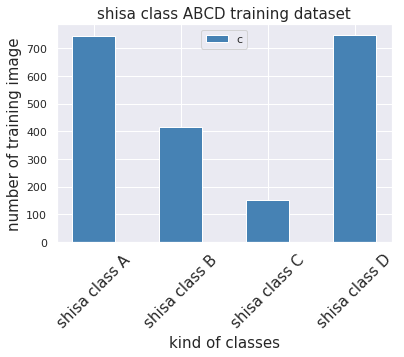

In [53]:

df = pd.read_csv("/home/seimei/Graduation_Research/src/path_and_label_train.csv")


all_row_num = len(df)
df = df.set_index("weather") 

left =np.array([0])
height = np.array([df.where((df["label"] == 0) & (df.index == "kumori") ).count()["label"]])
p=plt.bar(left, height,width=0.5,color='steelblue', align="center")

left1 =np.array([1])
height1 = np.array([df.where((df["label"] == 1) & (df.index == "kumori") ).count()["label"]])
p1=plt.bar(left1, height1,width=0.5,color='steelblue', align="center")

left2 =np.array([2])
height2 = np.array([df.where((df["label"] == 2) & (df.index == "kumori") ).count()["label"]])
p2=plt.bar(left2, height2,width=0.5,color='steelblue', align="center")

left3 =np.array([3])
height3 = np.array([df.where((df["label"] == 3) & (df.index == "kumori") ).count()["label"]])
p3=plt.bar(left3, height3,width=0.5,color='steelblue', align="center")

plt.xticks([0,1,2,3],["shisa class A","shisa class B","shisa class C","shisa class D"])

ax = plt.subplot(111)
    

sns.set()
plt.legend((p2),("cloudy"))
plt.xlabel("kind of classes", fontsize=15)
plt.ylabel("number of training image", fontsize=15)
plt.title("shisa class ABCD training dataset", fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=15)
#plt.savefig("/Users/masaaki/Desktop/train_graph.png")

data = [go.Bar(x=)]

py.iplot(data)

In [29]:
import matplotlib
import seaborn as sns

In [6]:
matplotlib.matplotlib_fname()

'/home/seimei/.config/matplotlib/matplotlibrc'

/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

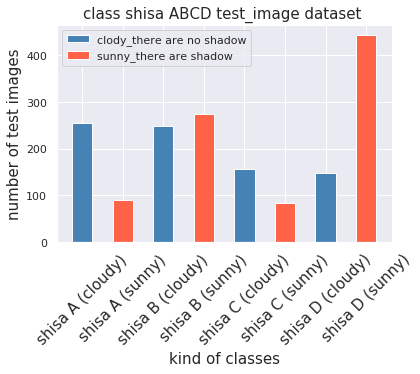

In [44]:
#　テスト用データーセット分布
df = pd.read_csv("/home/seimei/Graduation_Research/src/path_and_label_test.csv")
all_row_num =len(df)
df=df.set_index("weather")


left =np.array([0])
height = np.array([df.where((df["label"] == 0) & (df.index == "kumori") ).count()["label"]])
p=plt.bar(left, height,width=0.5,color='steelblue', align="center")

left1 =np.array([1])
height1 = np.array([df.where((df["label"] == 0) & (df.index == "hare") ).count()["label"]])
p1=plt.bar(left1, height1,width=0.5,color='tomato', align="center")


left2 =np.array([2])
height2 = np.array([df.where((df["label"] == 1) & (df.index == "kumori") ).count()["label"]])
p2=plt.bar(left2, height2,width=0.5,color='steelblue', align="center")

left3 =np.array([3])
height3 = np.array([df.where((df["label"] == 1) & (df.index == "hare") ).count()["label"]])
p3=plt.bar(left3, height3,width=0.5,color='tomato', align="center")


left4 =np.array([4])
height4 = np.array([df.where((df["label"] == 2) & (df.index == "kumori") ).count()["label"]])
p4=plt.bar(left4, height4,width=0.5,color='steelblue', align="center")

left5 =np.array([5])
height5 = np.array([df.where((df["label"] == 2) & (df.index == "hare") ).count()["label"]])
p5=plt.bar(left5, height5,width=0.5,color='tomato', align="center")


left6 =np.array([6])
height6 = np.array([df.where((df["label"] == 3) & (df.index == "kumori") ).count()["label"]])
p6=plt.bar(left6, height6,width=0.5,color='steelblue', align="center")

left7 =np.array([7])
height7 = np.array([df.where((df["label"] == 3) & (df.index == "hare") ).count()["label"]])
p7=plt.bar(left7, height7,width=0.5,color='tomato', align="center")



plt.xticks([0,1,2,3,4,5,6,7],["shisa A (cloudy)","shisa A (sunny)",
                              "shisa B (cloudy)","shisa B (sunny)",
                              "shisa C (cloudy)","shisa C (sunny)",
                              "shisa D (cloudy)","shisa D (sunny)"])

ax = plt.subplot(111)
sns.set()
plt.legend((p,p1),("clody_there are no shadow","sunny_there are shadow"))

plt.xlabel("kind of classes", fontsize=15)
plt.ylabel("number of test images", fontsize=15)
plt.title("class shisa ABCD test_image dataset ", fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45, fontsize=15)

#plt.savefig("/Users/masaaki/Desktop/test_graph.png")

In [12]:
df = pd.read_csv("/home/seimei/Graduation_Research/src/path_and_label_test.csv")
df.head()

,weather,path,label
0,hare,/home/seimei/Graduation_Research/dataset_valid...,0
1,hare,/home/seimei/Graduation_Research/dataset_valid...,0
2,hare,/home/seimei/Graduation_Research/dataset_valid...,0
3,hare,/home/seimei/Graduation_Research/dataset_valid...,0
4,hare,/home/seimei/Graduation_Research/dataset_valid...,0


## Create Input Pipline

In [ ]:
# Serialize images, together with labels, to TF records
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

tf_records_filename = './input_pipline/OutdoorTFRecord_{}'.format(IM_SIZE)
writer = tf.python_io.TFRecordWriter(tf_records_filename)

# List of image paths, np array of labels
im_list = [os.path.join('./input_pipline/train', v+'.jpg') for v in df_train['image_name'].tolist()]
w_labels_arr = np.array([ast.literal_eval(l) for l in df_train['weather_labels']])


# Loop over images and labels, wrap in TF Examples, write away to TFRecord file
for i in range(len(df_train)):
    w_labels = w_labels_arr[i].astype(np.float32)
    im = np.array(img_to_array(load_img(im_list[i], target_size=[IM_SIZE, IM_SIZE]))/255.)
    
    example = tf.train.Example(features=tf.train.Features(feature={'image': _bytes_feature(im.tostring()),
                                                                  'weather_labels': _bytes_feature(w_labels.tostring())}))    

    writer.write(example.SerializeToString())

writer.close()    

In [ ]:
url="/home/seimei/Graduation_Research/dataset/hare/hare_D2/image_0037.jpg"
x=cv2.imread(url)
img = cv2.resize(x,(300,300))
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))

In [17]:
print(type(img_hsv))

shape=[300,300,3]
x = tf.placeholder(dtype=tf.float32, shape=shape)
flip_2 = tf.image.flip_up_down(x)

init = tf.global_variables_initializer() 
with tf.Session() as  sess:
    init.run()
    sess.run(flip_2)
    img=cv2.resize(x,(300,300))
    img_hsv=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
x=cv2.imread(url)
img = cv2.resize(x,(300,300))
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
plt.imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))

<class 'numpy.ndarray'>


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_6' with dtype float and shape [300,300,3]
	 [[{{node Placeholder_6}} = Placeholder[dtype=DT_FLOAT, shape=[300,300,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node flip_up_down_6/ReverseV2/_1}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7_flip_up_down_6/ReverseV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_6', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-e30cf2c2c24f>", line 4, in <module>
    x = tf.placeholder(dtype=tf.float32, shape=shape)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1745, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5020, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/home/seimei/usr/bin/virtualenv/tensorflow-with-gpu/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_6' with dtype float and shape [300,300,3]
	 [[{{node Placeholder_6}} = Placeholder[dtype=DT_FLOAT, shape=[300,300,3], _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node flip_up_down_6/ReverseV2/_1}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_7_flip_up_down_6/ReverseV2", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [19]:
import keras.preprocessing.image


In [57]:
df=pd.DataFrame({"image_name":["train_0","train_1","train_2","train_3","train_4"]
              ,"tags": ["haze primary","agriculture clear primary water",
                        "clear primary","clear primary","agriculture clear habitation "]})
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation


In [65]:
labels = df['tags'].apply(lambda x: x.split(' '))
labels.tolist()

[['haze', 'primary'],
 ['agriculture', 'clear', 'primary', 'water'],
 ['clear', 'primary'],
 ['clear', 'primary'],
 ['agriculture', 'clear', 'habitation', '']]